In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

PREFIX='a video of '

In [5]:
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    all_classes = [normal_class] + anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array
    fn_stored=0
    tn_stored=0
    for i in range(len(predicted_events)):
        # Get ground truth
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        pred_class = predicted_events[i]
        if prompts[i] == "" and mode==0:
            pass
            '''elif pred_class==normal_class:
            if is_anomaly == 0:
                tn_stored += 1
            else:
                fn_stored += 1
            continue'''
        elif prompts[i] == "yes":
            pass
        elif prompts[i] == "no":
            continue
        else:
            continue
        # Get predicted class
        
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    fn += fn_stored
    tn += tn_stored
    return tp, fp, fn, tn

In [6]:
events = [
        "Riding",
        "Fighting",
        "Playing",
        "Running",
        'Lying',
        "Chasing",
        "Jumping",
        "Falling",
        "Guiding",
        "Stealing",
        "Littering",
        "Tripping",
        "Pickpockering",
    ]
description = [
        "a person riding a bicycle on the street",  # Added context
        "multiple people engaged in a physical fight",  # More specific than "fighting"
        "a group of people playing a sport together",  # Added "sport" for visual clarity
        "a person running",  # Added context
        "a person lying motionless on the ground",  # "Motionless" helps distinguish from falling
        "a person aggressively chasing another person",  # "Aggressively" adds distinction
        "a person jumping high in the air with both feet",  # More specific than just "jumping"
        "a person accidentally falling to the ground",  # "Accidentally" helps distinguish
        "a person gently guiding another person by the arm",  # Added detail
        "a person stealing other person",  # More specific than "stealing"
        "a person deliberately throwing garbage on the ground",  # "Deliberately" adds clarity
        "a person tripping over an obstacle",  # More descriptive
        "a person pickpocketing a wallet from someone's pocket",  # Very specific
    ]

In [7]:
description=[PREFIX+desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [8]:

rute="/home/ubuntu/Database/ALL/Videos"
rute_stored='/home/ubuntu/Tesis/Storage/'
modes=[0,1]
usage='CLIP'
i=0
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
for mode in modes:
    for folder_number in range(len(events)):
        folder=f"{rute}/{events[folder_number]}/"
        files= os.listdir(folder)
        for file in files:
            stored_file=file.split('.')[0]
            info_stored=np.load(f"{rute_stored}{stored_file}_{usage}_{mode}_{events[folder_number]}.npy", allow_pickle=True)
            frames_number=info_stored[0]
            predicted_events=info_stored[1]
            prompts=info_stored[2]
            event= events_description[events[folder_number]]
            tp, fp,fn, tn=check_precision(frames_number, stored_file, predicted_events, event, description, prompts, mode)
            row = {
            'Name':stored_file, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
            }
            df =pd.concat([df, pd.DataFrame([row])], ignore_index=True)
print(df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/Tesis/Storage/000350_CLIP_0_Riding.npy'

In [ ]:
df_sum = df.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
print(df_sum)

                                                Event  Mode   TP   FP    FN  \
0   a video of a group of people playing a sport t...     0  233   35  7446   
1   a video of a group of people playing a sport t...     1  233   35  1564   
2   a video of a person accidentally falling to th...     0    1    0   902   
3   a video of a person accidentally falling to th...     1    1    0   291   
4   a video of a person aggressively chasing anoth...     0    0    0  2195   
5   a video of a person aggressively chasing anoth...     1    0    0   446   
6   a video of a person deliberately throwing garb...     0   73   96   416   
7   a video of a person deliberately throwing garb...     1   73   80   112   
8   a video of a person gently guiding another per...     0   22    0   647   
9   a video of a person gently guiding another per...     1   22    0    58   
10  a video of a person jumping high in the air wi...     0    0    0   309   
11  a video of a person jumping high in the air wi..

/tmp/ipykernel_9153/1677617368.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8694029850746269 0.8694029850746269 1.0 1.0 0.4319526627218935
 0.477124183006536 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.39251523063533506
 0.6481876332622601 1.0 1.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_9153/1677617368.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.03034249251204584 0.1296605453533667 0.0011074197120708748
 0.003424657534246575 0.0 0.0 0.1492842535787321 0.3945945945945946
 0.03288490284005979 0.275 0.0 0.0 0.2990074441687345 0.8185053380782918
 0.005494505494505495 0.0 0.1814033086138049 0.9506172839506173
 0.1912637828668363 0.5268630849220104 0.0 0.0 0.0 0.0 0.14744525547445256
 0.40388114008489995]' has dtyp

In [ ]:
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_check= df_sum.copy()
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean().reset_index()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

                                                Event  Mode   TP   FP    FN  \
0   a video of a group of people playing a sport t...     0  233   35  7446   
2   a video of a person accidentally falling to th...     0    1    0   902   
4   a video of a person aggressively chasing anoth...     0    0    0  2195   
6   a video of a person deliberately throwing garb...     0   73   96   416   
8   a video of a person gently guiding another per...     0   22    0   647   
10  a video of a person jumping high in the air wi...     0    0    0   309   
12  a video of a person lying motionless on the gr...     0  482    0  1130   
14  a video of a person pickpocketing a wallet fro...     0    2    0   362   
16  a video of a person riding a bicycle on the st...     0  318    0  1435   
18                        a video of a person running     0  451  698  1907   
20          a video of a person stealing other person     0    0    0   602   
22      a video of a person tripping over an obstacl

                                                Event  Mode Precision  \
0   a video of a group of people playing a sport t...     0  0.869403   
1   a video of a group of people playing a sport t...     1  0.869403   
2   a video of a person accidentally falling to th...     0       1.0   
3   a video of a person accidentally falling to th...     1       1.0   
4   a video of a person aggressively chasing anoth...     0       0.0   
5   a video of a person aggressively chasing anoth...     1       0.0   
6   a video of a person deliberately throwing garb...     0  0.431953   
7   a video of a person deliberately throwing garb...     1  0.477124   
8   a video of a person gently guiding another per...     0       1.0   
9   a video of a person gently guiding another per...     1       1.0   
10  a video of a person jumping high in the air wi...     0       0.0   
11  a video of a person jumping high in the air wi...     1       0.0   
12  a video of a person lying motionless on the gr.

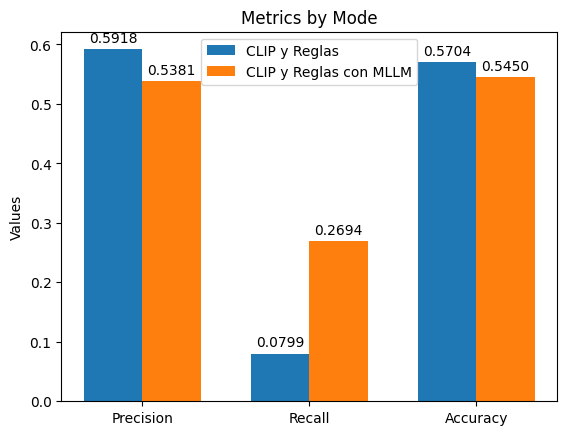

In [ ]:
print(df_check)
import matplotlib.pyplot as plt
#df_check=df_check[df_check['Event']!= events_description['Pickpockering']]
# Extract precision, recall, and accuracy for mode 0 and mode 1
metrics = ["Precision", "Recall", "Accuracy"]

# Ensure mode_0 and mode_1 contain only the metrics for Precision, Recall, and Accuracy
mode_0 = df_check[df_check["Mode"] == 0][metrics].mean().values.flatten()
mode_1 = df_check[df_check["Mode"] == 1][metrics].mean().values.flatten()

# Check if mode_0 and mode_1 have valid data
if mode_0.size == 0 or mode_1.size == 0:
    raise ValueError("Data for one or both modes is missing or invalid.")

# Create bar plot
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mode_0, width, label='CLIP y Reglas')
rects2 = ax.bar(x + width/2, mode_1, width, label='CLIP y Reglas con MLLM')

# Add labels, title, and legend
ax.set_ylabel('Values')
ax.set_title('Metrics by Mode')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels above the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show plot
plt.show()

In [ ]:
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
print(df_check)
df_check.drop(columns=['Event'], inplace=True)
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
    }
df_check.rename(index=mode_names, inplace=True)
print(df_check.groupby(["Mode"]).mean().reset_index())

                                                Event  Mode Precision  \
0   a video of a group of people playing a sport t...     0  0.869403   
1   a video of a group of people playing a sport t...     1  0.869403   
2   a video of a person accidentally falling to th...     0       1.0   
3   a video of a person accidentally falling to th...     1       1.0   
4   a video of a person aggressively chasing anoth...     0       0.0   
5   a video of a person aggressively chasing anoth...     1       0.0   
6   a video of a person deliberately throwing garb...     0  0.431953   
7   a video of a person deliberately throwing garb...     1  0.477124   
8   a video of a person gently guiding another per...     0       1.0   
9   a video of a person gently guiding another per...     1       1.0   
10  a video of a person jumping high in the air wi...     0       0.0   
11  a video of a person jumping high in the air wi...     1       0.0   
12  a video of a person lying motionless on the gr.

/tmp/ipykernel_9153/3601784075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
